# Tesis de Licenciatura en Astronomía



## Manuel López Vargas

## Detección de señales en series de tiempo de Blazares utilizando Ténicas de Machine Learning

In [1]:
from scipy.integrate import odeint
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import lombscargle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
import itertools
from numpy import *
import seaborn as sns
from sklearn.metrics import accuracy_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
import os
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.metrics import precision_score 
from imblearn.metrics import specificity_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
import warnings
import scipy.stats as stats
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import pycaret
from pycaret.classification import *

In [2]:
#Function to read the files and separate each AGN and its errors.

def agns(data):
    
    #Read the first column which is the Julian days.
    t = data[:,0]
    
    agn=[] #AGNs
    err_agn=[] #AGNs errors
    star=[] #Calibration Stars
    err_star=[] #Calibration Stars errors
    agn_p=[] #Variable AGNs
    err_agn_p=[] #Variable AGNs errors

    for i in range(1, 544, 2):

        if i <  400: 
 
            agns = data[:,i]
            err_agns = data[:,i+1]
            agn.append(agns)
            err_agn.append(err_agns)
            
        elif i > 400 and i < 526:
   
            stars = data[:,i]
            err_stars = data[:,i+1]
            star.append(stars)
            err_star.append(err_stars)
            
        elif i > 526: 

            agn_ps = data[:,i]
            err_agn_ps = data[:,i+1]
            agn_p.append(agn_ps)
            err_agn_p.append(err_agn_ps)
            
    return agn, err_agn, star, err_star, agn_p, err_agn_p, t
                                       
    

In [3]:
"""
We calibrate the observed fluxes of the AGNs using the calibration stars.

For this, we choose for each AGN the star that has the magnitude most similar to that of the AGN.

We use the mean of each star and AGN for comparison. 


We define a function that calculates the star with mean magnitude most similar to the AGN and then subtracts those magnitudes and this is what we will use to determine

whether an AGN is variable or not.
"""
def calibration(agn, star, err_agn, err_star):

    rest = []
    
    for i in range(63):

        resta = abs (np.mean(star[i])-np.mean(agn))

        rest.append(resta)
    
        ind_min = np.argmin(rest)

        cal = agn - star[ind_min] #Calibrated magnitude

        err_cal = err_agn + err_star[ind_min]#Error calibrated magnitude 
        
    return cal, err_cal

In [4]:
def extract_features(mag, mag_w_err):
    """
    Extract features from the time series data for use in machine learning models.

    :param mag: Magnitude data array.
    :return: Extracted features.
    """
    features = {
        'mag_mean': np.mean(mag),
        'mag_var': np.var(mag),
        'mag_skew': skew(mag),
        'mag_kurt': kurtosis(mag),
        'mag_w_e_mean': np.mean(mag_w_err),
        'mag_w_e_var': np.var(mag_w_err),
        'mag_w_e_skew': skew(mag_w_err),
        'mag_w_e_kurt': kurtosis(mag_w_err),
    }
    
    return features

In [5]:
def remove_outliers(df, column_names):
    """
    Remove outliers from a pandas DataFrame based on the interquartile range.

    :param df: Pandas DataFrame.
    :param column_names: List of column names to check for outliers.
    :return: DataFrame with outliers removed.
    """
    clean_df = df.copy()
    
    for column in column_names:
        Q1 = clean_df[column].quantile(0.10)
        Q3 = clean_df[column].quantile(0.90)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out the outliers
        clean_df = clean_df[(clean_df[column] >= lower_bound) & (clean_df[column] <= upper_bound)]
    
    return clean_df

In [6]:
#Create the dataframe 

def dataframe(df, N, p, star, err_star, c, x, An): # p is the value of the target variable. 1 for variable AGNs and 0 for non-viarable AGNs
                               # df and star must have the same subindex

    for i in range(N): # N: number of AGNs in the dataset

        if An == 3:
            
            agn_a = agns(df)[c]
            agn = agn_a[i]
    
            err_a = agns(df)[x]
            err_agn = err_a[i]

        else: 

            agn_a = agns_per(df)[c]
            agn = agn_a[i]
    
            err_a = agns_per(df)[x]
            err_agn = err_a[i]

        #Calculates the calibrated magnitude of the AGN
        mag = calibration(agn, star, err_agn, err_star)[0]
        err_mag = calibration(agn, star, err_agn, err_star)[1]

        rng = np.random.default_rng()
        t = rng.uniform(0, 2, N)

        if t[i] <= 1:

            mag_w_err = mag + err_mag

        else:

            mag_w_err = mag - err_mag

        # Extract features from the time series data
        features = extract_features(mag, mag_w_err)
        
        # Store the features and the target variable
        data_features.append(features)

        if p == 1:
            variability.append(1)
        else:
            variability.append(0)

    return data_features

In [7]:
#we go through all the subdirectories corresponding to each AGN and in each one all the files with different sintetics curvs 

path = '/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/' #path to main directory
filelist = os.listdir(path)

#Make empty list to store all paths to subdirectories in.
path2 = []
data_features = []
data_features1 = []
variability = []

for x in filelist:
    if x.startswith('orig'):
        path2.append(path + x+ '/')
    
    for i in path2:
        filelist2 = os.listdir(i)
        
        for j in filelist2:
            if j.endswith('.dat'):
                dt = np.loadtxt(i+j)
                 
                star = agns(dt)[2]
                err_star = agns(dt)[3]
                data_features = dataframe(dt, 200, 0, star, err_star, 0, 1, 3)
                data_features1 = dataframe(dt, 9, 1, star, err_star, 4, 5, 3)

                # Convert lists to a DataFrame
                features_df = pd.DataFrame(data_features)
                features_df = pd.DataFrame(data_features1)
                features_df['Variability'] = variability       
    path2 = []

In [8]:
features_df

,mag_mean,mag_var,mag_skew,mag_kurt,mag_w_e_mean,mag_w_e_var,mag_w_e_skew,mag_w_e_kurt,Variability
0,0.010925,0.000013,-0.040652,-0.912835,0.004800,0.000013,-0.071119,-0.895523,0
1,-0.014825,0.000015,0.046973,-0.469547,-0.008575,0.000016,0.029991,-0.550542,0
2,-0.010350,0.000018,-0.266768,-0.175051,-0.016625,0.000019,-0.178373,-0.274666,0
3,-0.004375,0.000033,-0.210232,0.500604,-0.010650,0.000033,-0.368762,0.797874,0
4,0.000800,0.000023,0.429434,0.295149,-0.005575,0.000023,0.358526,0.186011,0
...,...,...,...,...,...,...,...,...,...
5220,0.014050,0.012010,0.297835,-1.603264,0.005050,0.012064,0.299634,-1.609166,1
5221,0.007875,0.003598,-0.212056,-1.291822,-0.001050,0.003643,-0.222344,-1.296148,1
5222,0.000025,0.001727,0.374140,-0.896395,0.008950,0.001736,0.381997,-0.906512,1
5223,-0.011825,0.001101,-0.246812,-1.147553,-0.020750,0.001114,-0.230340,-1.191427,1


In [9]:
features_df['Variability'].value_counts()

Variability
0    5000
1     225
Name: count, dtype: int64

In [10]:
features_df.duplicated().sum()

510

In [11]:
features_df.drop_duplicates(inplace=True)

In [12]:
features_df['Variability'].value_counts()

Variability
0    4501
1     214
Name: count, dtype: int64

In [13]:
features_df.isna().sum()

mag_mean        0
mag_var         0
mag_skew        0
mag_kurt        0
mag_w_e_mean    0
mag_w_e_var     0
mag_w_e_skew    0
mag_w_e_kurt    0
Variability     0
dtype: int64

In [14]:
features_df.fillna(0, inplace=True)
features_df.dropna(inplace=True)

In [15]:
features_df.corr()

,mag_mean,mag_var,mag_skew,mag_kurt,mag_w_e_mean,mag_w_e_var,mag_w_e_skew,mag_w_e_kurt,Variability
mag_mean,1.000000,-0.040707,0.025572,0.029827,0.906720,-0.037566,0.026272,0.023449,-0.102018
mag_var,-0.040707,1.000000,-0.055923,-0.164525,-0.042630,0.998815,-0.050296,-0.165575,0.752215
mag_skew,0.025572,-0.055923,1.000000,0.045465,0.019941,-0.058154,0.790186,0.071898,-0.086685
mag_kurt,0.029827,-0.164525,0.045465,1.000000,0.032378,-0.157052,0.057868,0.885726,-0.225569
mag_w_e_mean,0.906720,-0.042630,0.019941,0.032378,1.000000,-0.042191,0.186849,0.027789,-0.094549
mag_w_e_var,-0.037566,0.998815,-0.058154,-0.157052,-0.042191,1.000000,-0.054340,-0.158620,0.748105
mag_w_e_skew,0.026272,-0.050296,0.790186,0.057868,0.186849,-0.054340,1.000000,0.084353,-0.077203
mag_w_e_kurt,0.023449,-0.165575,0.071898,0.885726,0.027789,-0.158620,0.084353,1.000000,-0.223764
Variability,-0.102018,0.752215,-0.086685,-0.225569,-0.094549,0.748105,-0.077203,-0.223764,1.000000


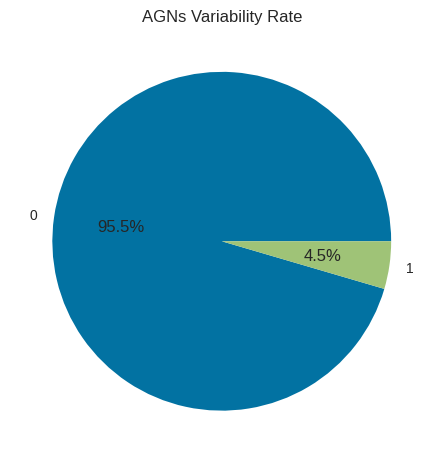

In [16]:
pie_x, pie_y = np.unique(features_df['Variability'], return_counts=True)
plt.pie(pie_y, labels=pie_x, autopct = '%1.1f%%') 
plt.title('AGNs Variability Rate')
plt.show()

#### As we can see, this dataset is very unbalanced.

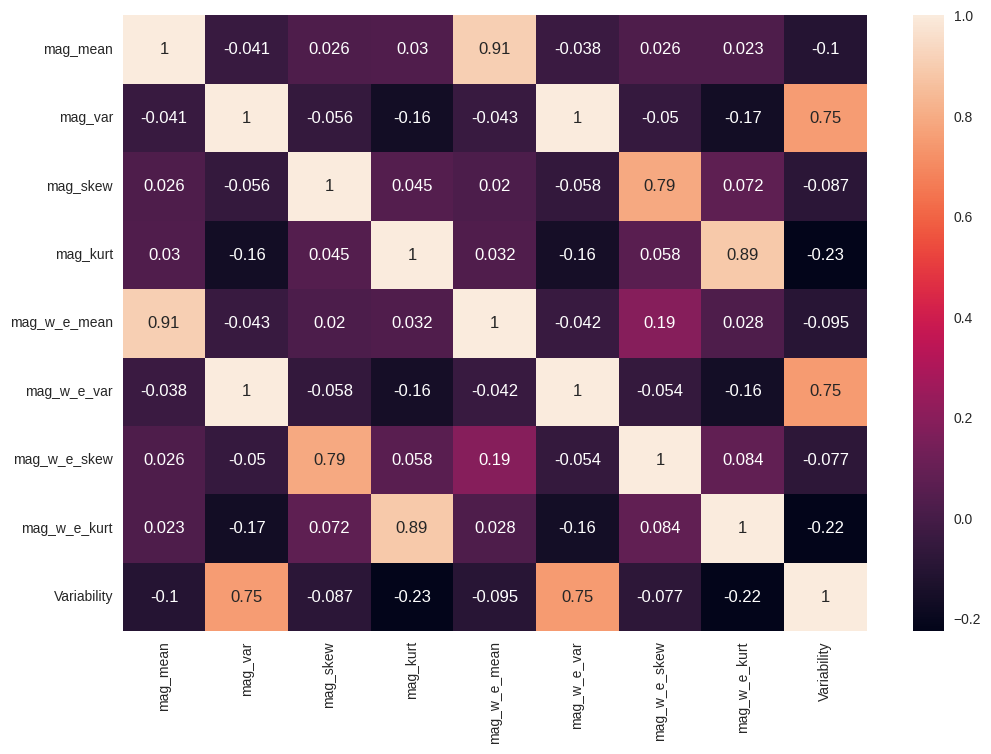

In [17]:
#Perform a correlation matrix to see how the data are related.

plt.figure(figsize=(12,8))
sns.heatmap(features_df.corr(), annot=True)
plt.show()

In [18]:
features_df.Variability.value_counts()

Variability
0    4501
1     214
Name: count, dtype: int64

In [19]:
df_0 = features_df[features_df['Variability'] == 0 ].sample(n=500)

In [20]:
df_0

,mag_mean,mag_var,mag_skew,mag_kurt,mag_w_e_mean,mag_w_e_var,mag_w_e_skew,mag_w_e_kurt,Variability
1360,0.000800,0.000029,0.608733,0.133750,0.008800,0.000029,0.608733,0.133750,0
4954,-0.004375,0.000427,0.002038,1.182305,-0.032150,0.000558,-0.734351,0.649744,0
4912,-0.005975,0.000176,-0.818774,0.893961,0.017000,0.000224,0.142712,-0.364043,0
1917,0.010000,0.000017,-0.275460,0.026267,0.016150,0.000018,-0.264617,-0.147829,0
3907,-0.013525,0.000139,0.234198,-0.160941,-0.032350,0.000143,0.244015,-0.145691,0
...,...,...,...,...,...,...,...,...,...
480,-0.010700,0.000022,0.419008,0.774949,-0.017850,0.000026,0.378187,0.774026,0
2252,0.008225,0.000105,0.278385,-0.256306,0.021350,0.000102,0.345883,0.035927,0
3662,-0.014775,0.000059,0.715962,1.353476,-0.024025,0.000060,0.365999,0.519785,0
3032,0.002750,0.000340,0.027342,-0.076528,0.024100,0.000374,0.369636,-0.171330,0


In [22]:
df_1 =  features_df[features_df['Variability'] == 1 ].sample(n=214)

In [23]:
df_1

,mag_mean,mag_var,mag_skew,mag_kurt,mag_w_e_mean,mag_w_e_var,mag_w_e_skew,mag_w_e_kurt,Variability
3126,-0.013825,0.003425,-0.037204,-1.261974,-0.028650,0.003811,-0.074744,-1.269301,1
2087,-0.003475,0.003269,-0.509732,0.165999,0.003525,0.003269,-0.509732,0.165999,1
3339,0.009675,0.007795,-0.276758,-1.315512,0.000750,0.007781,-0.281132,-1.311581,1
625,-0.012050,0.001070,-0.117539,-1.419562,-0.005050,0.001070,-0.117539,-1.419562,1
2290,-0.011700,0.003453,-0.014860,-1.178715,-0.019450,0.003362,-0.005888,-1.197631,1
...,...,...,...,...,...,...,...,...,...
4801,-0.005050,0.001052,-0.683573,-0.919287,0.003325,0.001031,-0.686291,-0.953607,1
200,-0.012175,0.003481,0.009732,-1.166892,-0.005375,0.003580,0.018974,-1.181231,1
1670,0.013050,0.001090,-0.363238,-0.726833,0.030575,0.001083,-0.335416,-0.777641,1
1248,-0.006400,0.000968,-0.691676,-0.863887,-0.012400,0.000968,-0.691676,-0.863887,1


In [24]:
df = pd.concat([df_0, df_1])

In [25]:
df.index =  range(df.shape[0])

In [26]:
df

,mag_mean,mag_var,mag_skew,mag_kurt,mag_w_e_mean,mag_w_e_var,mag_w_e_skew,mag_w_e_kurt,Variability
0,0.000800,0.000029,0.608733,0.133750,0.008800,0.000029,0.608733,0.133750,0
1,-0.004375,0.000427,0.002038,1.182305,-0.032150,0.000558,-0.734351,0.649744,0
2,-0.005975,0.000176,-0.818774,0.893961,0.017000,0.000224,0.142712,-0.364043,0
3,0.010000,0.000017,-0.275460,0.026267,0.016150,0.000018,-0.264617,-0.147829,0
4,-0.013525,0.000139,0.234198,-0.160941,-0.032350,0.000143,0.244015,-0.145691,0
...,...,...,...,...,...,...,...,...,...
709,-0.005050,0.001052,-0.683573,-0.919287,0.003325,0.001031,-0.686291,-0.953607,1
710,-0.012175,0.003481,0.009732,-1.166892,-0.005375,0.003580,0.018974,-1.181231,1
711,0.013050,0.001090,-0.363238,-0.726833,0.030575,0.001083,-0.335416,-0.777641,1
712,-0.006400,0.000968,-0.691676,-0.863887,-0.012400,0.000968,-0.691676,-0.863887,1


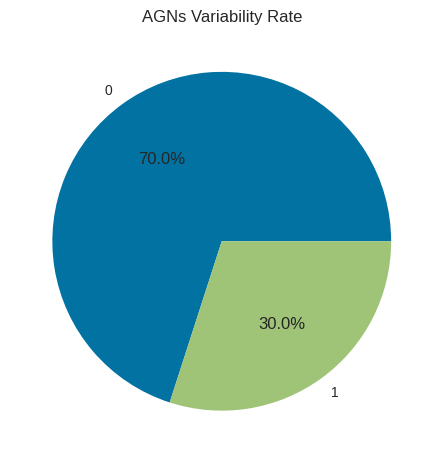

In [27]:
pie_x, pie_y = np.unique(df['Variability'], return_counts=True)
plt.pie(pie_y, labels=pie_x, autopct = '%1.1f%%') 
plt.title('AGNs Variability Rate')
plt.show()

### Machine Learning models

In [28]:
#Apply a Machine Learning model, a Logistic Regression.

data1 = features_df.copy()

X = data1.drop('Variability', axis=1)[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
y = data1['Variability']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20, stratify = y)

# Initialize the Random Forest Classifier
clf = LogisticRegression(random_state=0)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
r2_score(y_pred, y_test)

-3.7065811356616765

We'll try to improve the model.

In [29]:
#Apply a Random Forest classifier with the original dataset.

data = features_df.copy()

# Split the data into features and target
X = data.drop('Variability', axis=1)[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
y = data['Variability']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20, stratify = y)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(max_depth=10)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy_score(y_pred,y_test)

0.9957597173144876

In [30]:
#Another Machine Learning model, a Random Forest classifier with an UnderSampling.

# Split the data into features and target
X = df.drop('Variability', axis=1)[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
y = df['Variability']

# Split the dataset into training and testing sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.2, random_state=20, stratify = y)

# Initialize the Random Forest Classifier
rf_classifier1 = RandomForestClassifier(max_depth=10)

# Train the model
rf_classifier1.fit(X1_train, y1_train)

# Make predictions on the test set
y1_pred = rf_classifier1.predict(X1_test)

# Evaluate the model
accuracy_score(y1_pred,y1_test)

0.9790209790209791

In [31]:
#Another Machine Learning model, a Random Forest classifier with an OverSampling.

data_1 = features_df.copy()

# Split the data into features and target
X = data_1.drop('Variability', axis=1)[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
y = data_1['Variability']

ros = RandomOverSampler(random_state=20, sampling_strategy='minority')

X_res, y_res = ros.fit_resample(X, y)

# Split the dataset into training and testing sets
X11_train, X11_test, y11_train, y11_test = train_test_split(X_res, y_res, test_size=0.3, random_state=20, stratify = y_res)

# Initialize the Random Forest Classifier
rf_classifier11 = RandomForestClassifier(max_depth=10)

# Train the model
rf_classifier11.fit(X11_train, y11_train)

# Make predictions on the test set
y11_pred = rf_classifier11.predict(X11_test)

# Evaluate the model
accuracy_score(y11_pred,y11_test)

0.9970381340244354

#### We use the metrics to evaluate the model

Metrics of first Random Forest Model

In [32]:
confusion = metrics.confusion_matrix(y_test, y_pred)
confusion.ravel()

array([1351,    0,    6,   58])

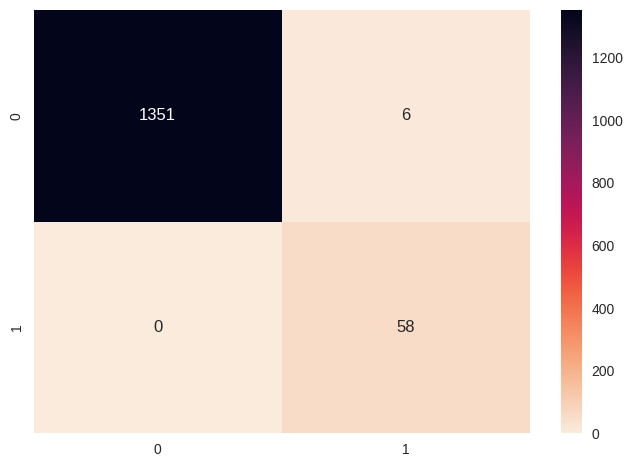

In [33]:
mc=confusion_matrix(y_pred,y_test)
mc_norm = mc / np.linalg.norm(mc, axis=1, keepdims=True)
sns.heatmap(pd.DataFrame(mc), cmap=sns.cm.rocket_r, annot=True, fmt='.5g');

In [34]:
cross_val_score(rf_classifier,X_train,y_train,cv=3,scoring='precision').mean()

1.0

In [35]:
cross_val_score(rf_classifier,X_train,y_train,cv=3,scoring='recall').mean()

0.8666666666666667

In [36]:
cross_val_score(rf_classifier,X_train,y_train,cv=3,scoring='f1').mean()

0.9284613012642615

Metrics of model with UnderSampling

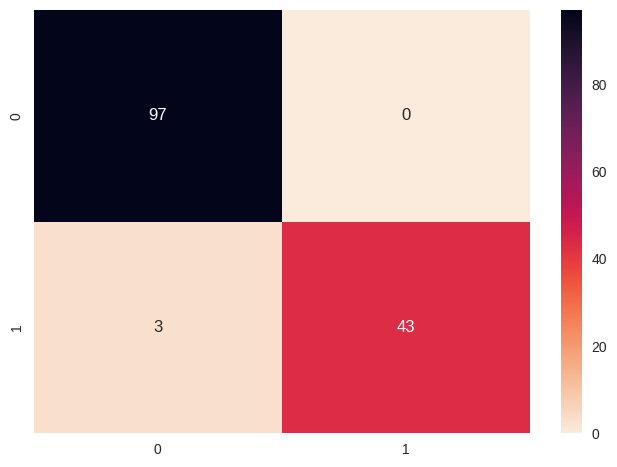

In [37]:
mc=confusion_matrix(y1_pred,y1_test)
mc_norm = mc / np.linalg.norm(mc, axis=1, keepdims=True)
sns.heatmap(pd.DataFrame(mc), cmap=sns.cm.rocket_r, annot=True, fmt='.5g');

In [38]:
cross_val_score(rf_classifier1,X1_train,y1_train,cv=3,scoring='precision').mean()

0.9708500614126748

In [39]:
cross_val_score(rf_classifier1,X1_train,y1_train,cv=3,scoring='recall').mean()

0.9590643274853802

In [40]:
cross_val_score(rf_classifier1,X1_train,y1_train,cv=3,scoring='f1').mean()

0.9617018209239913

Metrics of model with OverSampling

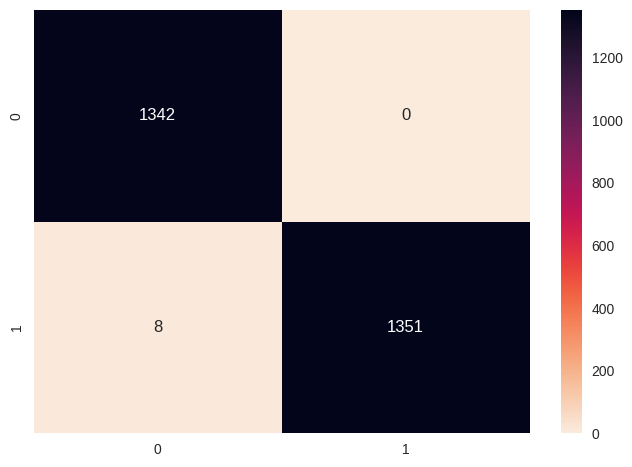

In [41]:
mc=confusion_matrix(y11_pred,y11_test)
mc_norm = mc / np.linalg.norm(mc, axis=1, keepdims=True)
sns.heatmap(pd.DataFrame(mc), cmap=sns.cm.rocket_r, annot=True, fmt='.5g');

In [42]:
cross_val_score(rf_classifier11,X11_train,y11_train,cv=3,scoring='precision').mean()

0.9940099656751001

In [43]:
cross_val_score(rf_classifier11,X11_train,y11_train,cv=3,scoring='recall').mean()

1.0

In [44]:
cross_val_score(rf_classifier11,X11_train,y11_train,cv=3,scoring='f1').mean()

0.9969938445885714

#### The second Random Forest model its better, so we will use this one.

In [45]:
#Precision score
precision_score(y11_pred, y11_test)

1.0

In [46]:
#Specificity score
specificity_score(y11_pred,y11_test)

1.0

In [47]:
#ROC AUC score
roc_auc_score(y11_pred,y11_test)

0.997056659308315

In [48]:
#Recall score
recall_score(y11_test, y11_pred) 

1.0

In [49]:
#F1 score
f1_score(y11_test, y11_pred) 

0.9970479704797048

In [50]:
print(classification_report(y11_test,y11_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1350
           1       0.99      1.00      1.00      1351

    accuracy                           1.00      2701
   macro avg       1.00      1.00      1.00      2701
weighted avg       1.00      1.00      1.00      2701



### Lets try whit a grid search to improve the model

In [51]:
params = {
        'n_estimators' : [80,84,88,92,96,100,104,108,112,116,120],
        'max_depth': [3,4,5,6,7,8,9,10],
        'criterion':['entropy','gini']
        }

In [52]:
#Compute de grid search

grid_cv = GridSearchCV(rf_classifier1, params, scoring="f1", n_jobs=-1, cv=3)
grid_cv.fit(X1_train, y1_train)

print("Mejores Parametros", grid_cv.best_params_)
print("Mejor CV score", grid_cv.best_score_)
print(f'F1 score del modelo = {round(recall_score(y1_test, grid_cv.predict(X1_test)), 5)}')

Mejores Parametros {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 116}
Mejor CV score 0.968061109951157
F1 score del modelo = 1.0


In [53]:
#Compute de grid search

grid_cv = GridSearchCV(rf_classifier11, params, scoring="f1", n_jobs=-1, cv=3)
grid_cv.fit(X11_train, y11_train)

print("Mejores Parametros", grid_cv.best_params_)
print("Mejor CV score", grid_cv.best_score_)
print(f'F1 score del modelo = {round(recall_score(y11_test, grid_cv.predict(X11_test)), 5)}')

Mejores Parametros {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
Mejor CV score 0.9971520469755291
F1 score del modelo = 1.0


## PyCaret AutoML

In [54]:
features_df['Variability'].value_counts()

Variability
0    4501
1     214
Name: count, dtype: int64

In [55]:
features_df.columns

Index(['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt', 'mag_w_e_mean',
       'mag_w_e_var', 'mag_w_e_skew', 'mag_w_e_kurt', 'Variability'],
      dtype='object')

In [56]:
# import pycaret for clasiification, the dataset is features_df and the target variable is Variability is very desbalanced
# we will use the SMOTE method to balance the dataset.

# Setup the classification model
clf1 = setup(data=features_df[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt','Variability']], target='Variability',fix_imbalance=True)

,Description,Value
0,Session id,746
1,Target,Variability
2,Target type,Binary
3,Original data shape,"(4715, 5)"
4,Transformed data shape,"(7715, 5)"
5,Transformed train set shape,"(6300, 5)"
6,Transformed test set shape,"(1415, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


In [57]:
# Compare the performance of different classification models
best_model = compare_models(include = ['lr', 'knn', 'dt', 'rf', 'xgboost'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9921,0.9974,0.9533,0.8902,0.9185,0.9144,0.9162,0.0680
rf,Random Forest Classifier,0.9915,0.9950,0.9333,0.8942,0.9099,0.9055,0.9076,0.3770
dt,Decision Tree Classifier,0.9909,0.9667,0.9400,0.8793,0.9056,0.9008,0.9031,0.0340
knn,K Neighbors Classifier,0.8848,0.8455,0.7333,0.2455,0.3667,0.3205,0.3800,0.0570
lr,Logistic Regression,0.8133,0.9097,0.8400,0.1776,0.2926,0.2352,0.3310,0.1930


In [58]:
best_model

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, objective='binary:logistic', ...)

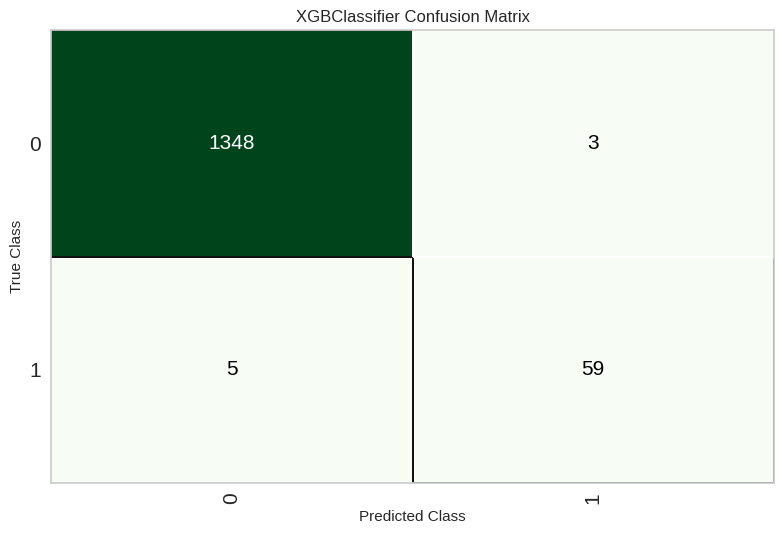

In [59]:
# plot confusion matrix
plot_model(best_model, plot = 'confusion_matrix')

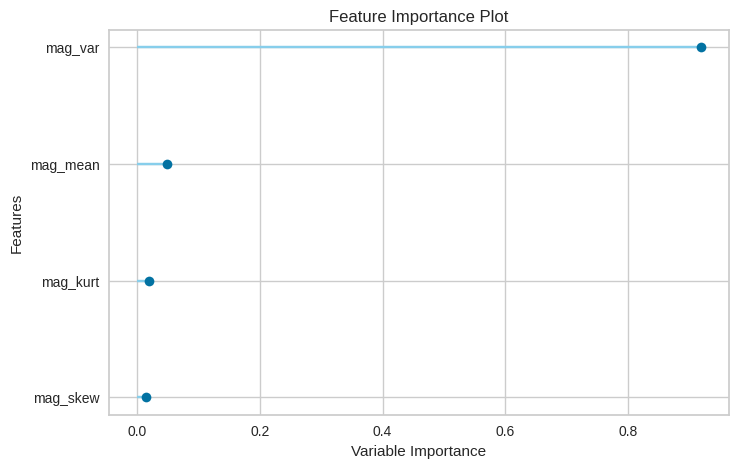

In [60]:
# plot feature importance
plot_model(best_model, plot = 'feature')

In [61]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [62]:
tuned_model = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9939,0.9987,0.9333,0.9333,0.9333,0.9302,0.9302
1,0.9909,0.9977,0.9333,0.8750,0.9032,0.8985,0.8990
2,0.9970,1.0000,1.0000,0.9375,0.9677,0.9662,0.9667
3,0.9909,0.9989,0.9333,0.8750,0.9032,0.8985,0.8990
4,0.9879,0.9810,0.9333,0.8235,0.8750,0.8687,0.8705
5,0.9909,1.0000,1.0000,0.8333,0.9091,0.9043,0.9085
6,0.9939,0.9989,0.8667,1.0000,0.9286,0.9254,0.9280
7,0.9970,0.9994,0.9333,1.0000,0.9655,0.9639,0.9646
8,0.9879,1.0000,1.0000,0.7895,0.8824,0.8761,0.8829


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [63]:
tuned_model

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=-1,
              num_parallel_tree=None, objective='binary:logistic', ...)

In [64]:
# predict on test set
holdout_pred = predict_model(tuned_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9929,0.9965,0.9062,0.9355,0.9206,0.9169,0.9171


In [65]:
# save the model in a variable to use for prediction
final_best_model = finalize_model(tuned_model)

In [66]:
# show predictions df
holdout_pred.head()

,mag_mean,mag_var,mag_skew,mag_kurt,Variability,prediction_label,prediction_score
1663,-0.012875,0.003438,0.048720,-0.997961,1,1,0.9997
4626,0.000275,0.000029,-0.230293,0.368718,0,0,1.0000
4447,-0.001050,0.000027,-0.213696,-0.173172,0,0,1.0000
2690,0.047125,0.000323,-0.346751,-0.617524,0,0,0.9994
2073,0.100175,0.000074,0.035660,-0.908202,0,0,0.9999


### Now we'll use real observations of some AGNs to classify them.  

In [67]:
#Function to read the observations and separate each AGN and calibration Stars.

def agns1(data):
    
    #Read the first column which is the Julian days.
    t = data[:,0]
    
    agn=data[:,1] #AGN magnitude
    cal_star=[] #Calibration Stars
    
    for i in range(2, 9, 1):

        if i != 6 and i != 8:

            stars = data[:,i]
            cal_star.append(stars)

    return agn, cal_star, t

In [68]:
def calibration1(agn, star):

    rest = []
    
    for i in range(5):

        resta = abs (np.mean(star[i])-np.mean(agn))

        rest.append(resta)
    
        ind_min = np.argmin(rest)

        cal = agn - star[ind_min] #Calibrated magnitude
            
    return cal

In [69]:
def subsample_time_series(mag, t, subsample_size=30):
    """
    Subsample the time series data to simulate incomplete observations.

    :param t: AGN magnitudes
    :param subsample_size: The number of data points to subsample to.
    :return: Subsampled time series data mag.
    """
    # Ensure we always subsample the same way for reproducibility
    np.random.seed(0)
    
    # Choose random indices for subsampling
    subsample_indices = np.random.choice(len(t), size=subsample_size, replace=False)
    subsample_indices.sort()  # Sort the indices to maintain the time order
    
    return mag[subsample_indices], t[subsample_indices]

In [70]:
def extract_features_obs(mag,n, mag_w_err):
    """
    Extract features from the time series data for use in machine learning models.

    :param mag: Magnitude data array.
    :return: Extracted features.
    """
    features = {
        'mag_mean': np.mean(mag),
        'mag_var': np.var(mag),
        'mag_skew': skew(mag),
        'mag_kurt': kurtosis(mag),
    }

    err_features = {
        'err_mean_m': np.mean(mag)/n,
        'err_var_m': np.var(mag)/n,
        'err_skew_m': skew(mag)/n,
        'err_kurt_m': skew(mag)/n,
    }

    features_w_e = {
        'mag_mean': np.mean(mag),
        'mag_var': np.var(mag),
        'mag_skew': skew(mag),
        'mag_kurt': kurtosis(mag),
    }
    
    return features, features_w_e, err_features

In [71]:
#Create a dataframe for the observations an save it to a CSV file

def dataframe_obs(df): 
    
    D1 = df['D1'] #Diference between AGN and calibration star magnitudes
    err_D1 = df['eD1'] #error of the diference between AGN and calibration star magnitudes
    D2 = df['D2'] #Diference between calibratoin and control star magnitudes
    err_D2 = df['eD2'] #error of the diference between AGN and calibration star magnitudes

    #Calculates the Diference between D1 and D2
    mag = abs(D1-D2)
    err_obs = err_D1 + err_D2
    n = len(mag)

    rng = np.random.default_rng()
    t = rng.uniform(0, 2, 100)

    if t.any() <= 1:

        mag_w_err = mag + err_obs

    else:

        mag_w_err = mag - err_obs
        
    # Subsample the time series data to simulate incomplete observations
    #mag_subsampled = subsample_time_series(mag, t, subsample_size)        
    
    # Extract features from the time series data
    features_obs = extract_features_obs(mag, n, mag_w_err)[0]
    err_features_obs = extract_features_obs(mag, n, mag_w_err)[1]
    
    return features_obs, err_features_obs

In [72]:
#List all the AGNs, each one is a directory

dir = '/home/anakin/Documents/Tesis/Codigo/AGNs/'
names_agns = os.listdir(dir)
names_agns 

['agn_1424',
 'agn_0521',
 'agn_1116',
 'agn_1229',
 'agn_1958',
 'agn_1510',
 'agn_1256',
 'agn_0208',
 'agn_2005',
 'agn_1917',
 'agn_2310',
 'agn_0847',
 'agn_1127',
 'agn_0414',
 'agn_1443',
 'agn_2149',
 'agn_2126',
 'agn_2155']

In [73]:
#we go through all the subdirectories corresponding to each AGN and in each one all the files with different observations and we make a classification for each observation.

path = '/home/anakin/Documents/Tesis/Codigo/AGNs/' #path to main directory
filelist = os.listdir(path)
df_obs = []
names1 = []
observations = []
k=0
#Make empty list to store all paths to subdirectories in.
path2 = []
for x in filelist:
    if x.startswith('agn'):
        path2.append(path + x+ '/')

for i in path2:
    filelist2 = os.listdir(i)
    c=0
    p=0
    for j in filelist2:
        if j.endswith('.csv'):
            file = pd.read_csv(i+j, dtype=np.float64, na_values='INDEF')
            long= len(file['D1'])

            data_features_obs = []

            features_obs = dataframe_obs(file)[0]
            
            # Store the features 
            data_features_obs.append(features_obs)    
                
            # Convert lists to a DataFrame
            features_df_var = pd.DataFrame(data_features_obs)

            # Predict with the model
            predicted = final_best_model.predict(features_df_var)
            #predicted = predict_model(final_best_model, data=features_df_var)
    
            print(j, ':Classified', predicted, 'with', long, 'observations')

            c+=1
            if predicted == 1:
                
                df_obs.append(features_obs)
                names1.append(j)
                observations.append(long)

                p+=1
                
    prob = p/c*100

    print('-------------------------------------------------',names_agns[k], 'is variable whit a probability of:', prob, '%')
    k+=1

# Convert lists to a DataFrame
df_obs = pd.DataFrame(df_obs)
df_obs['AGN_n_obs'] = names1
df_obs['Observations'] = observations
 # Save the DataFrame to a CSV file
#df_obs.to_csv('observations_AGNs.csv', index=False)


1424R-140415.csv :Classified [0] with 9 observations
1424V-140415.csv :Classified [1] with 9 observations
------------------------------------------------- agn_1424 is variable whit a probability of: 50.0 %
0521V-111215.csv :Classified [0] with 21 observations
0521R-111215.csv :Classified [0] with 20 observations
------------------------------------------------- agn_0521 is variable whit a probability of: 0.0 %
1116R-130415.csv :Classified [0] with 15 observations
1116R-140415.csv :Classified [0] with 12 observations
1116V-130415.csv :Classified [1] with 15 observations
1116V-140415.csv :Classified [1] with 12 observations
------------------------------------------------- agn_1116 is variable whit a probability of: 50.0 %
1229V-120415.csv :Classified [0] with 13 observations
1229R-120415.csv :Classified [0] with 13 observations
------------------------------------------------- agn_1229 is variable whit a probability of: 0.0 %
1958V-230414.csv :Classified [0] with 11 observations
1958R-

In [74]:
df_obs

,mag_mean,mag_var,mag_skew,mag_kurt,AGN_n_obs,Observations
0,0.040444,0.000665,0.501270,-0.884148,1424V-140415.csv,9
1,0.112933,0.000857,0.050781,-1.129494,1116V-130415.csv,15
2,0.227833,0.001494,0.611344,-1.191094,1116V-140415.csv,12
3,0.482750,0.003018,1.471751,1.302412,1510V-040419.csv,8
4,0.855000,0.001063,0.065795,-1.326321,0208R-130815.csv,9
5,1.327667,0.002670,0.494768,-1.370405,0208V-150915.csv,6
6,0.685889,0.000977,-0.312898,-1.128564,0208V-130815.csv,9
7,0.687000,0.001165,0.488886,-1.020814,2149V-120815.csv,4
8,0.678071,0.000681,0.542535,-0.866700,2155V-150915.csv,14


#### Now we wiil predict using the magnitudes with erros variables. We do this to verify if the observationals errors are sufficiently significant to change our predictions.

In [75]:
#we go through all the subdirectories corresponding to each AGN and in each one all the files with different observations and we make a classification for each observation.

path = '/home/anakin/Documents/Tesis/Codigo/AGNs/' #path to main directory
filelist = os.listdir(path)
df_obs_err = []
names1 = []
observations = []
k=0
#Make empty list to store all paths to subdirectories in.
path2 = []
for x in filelist:
    if x.startswith('agn'):
        path2.append(path + x+ '/')

for i in path2:
    filelist2 = os.listdir(i)
    c=0
    p=0
    for j in filelist2:
        if j.endswith('.csv'):
            file = pd.read_csv(i+j, dtype=np.float64, na_values='INDEF')
            long= len(file['D1'])

            err_features_obs = []

            features_obs = dataframe_obs(file)[1]
            
            # Store the features 
            err_features_obs.append(features_obs)    
                
            # Convert lists to a DataFrame
            features_df_var = pd.DataFrame(err_features_obs)

            # Predict with the model
            predicted = final_best_model.predict(features_df_var)
    
            print(j, ':Classified', predicted, 'with', long, 'observations')

            c+=1
            if predicted == 1:
                
                df_obs_err.append(features_obs)
                names1.append(j)
                observations.append(long)

                p+=1
                
    prob = p/c*100

    print('-------------------------------------------------',names_agns[k], 'is variable whit a probability of:', prob, '%')
    k+=1

# Convert lists to a DataFrame
df_obs_err = pd.DataFrame(df_obs_err)
df_obs_err['AGN_n_obs'] = names1
df_obs_err['Observations'] = observations

1424R-140415.csv :Classified [0] with 9 observations
1424V-140415.csv :Classified [1] with 9 observations
------------------------------------------------- agn_1424 is variable whit a probability of: 50.0 %
0521V-111215.csv :Classified [0] with 21 observations
0521R-111215.csv :Classified [0] with 20 observations
------------------------------------------------- agn_0521 is variable whit a probability of: 0.0 %
1116R-130415.csv :Classified [0] with 15 observations
1116R-140415.csv :Classified [0] with 12 observations
1116V-130415.csv :Classified [1] with 15 observations
1116V-140415.csv :Classified [1] with 12 observations
------------------------------------------------- agn_1116 is variable whit a probability of: 50.0 %
1229V-120415.csv :Classified [0] with 13 observations
1229R-120415.csv :Classified [0] with 13 observations
------------------------------------------------- agn_1229 is variable whit a probability of: 0.0 %
1958V-230414.csv :Classified [0] with 11 observations
1958R-

In [76]:
df_obs_err

,mag_mean,mag_var,mag_skew,mag_kurt,AGN_n_obs,Observations
0,0.040444,0.000665,0.501270,-0.884148,1424V-140415.csv,9
1,0.112933,0.000857,0.050781,-1.129494,1116V-130415.csv,15
2,0.227833,0.001494,0.611344,-1.191094,1116V-140415.csv,12
3,0.482750,0.003018,1.471751,1.302412,1510V-040419.csv,8
4,0.855000,0.001063,0.065795,-1.326321,0208R-130815.csv,9
5,1.327667,0.002670,0.494768,-1.370405,0208V-150915.csv,6
6,0.685889,0.000977,-0.312898,-1.128564,0208V-130815.csv,9
7,0.687000,0.001165,0.488886,-1.020814,2149V-120815.csv,4
8,0.678071,0.000681,0.542535,-0.866700,2155V-150915.csv,14


In [77]:
df_obs

,mag_mean,mag_var,mag_skew,mag_kurt,AGN_n_obs,Observations
0,0.040444,0.000665,0.501270,-0.884148,1424V-140415.csv,9
1,0.112933,0.000857,0.050781,-1.129494,1116V-130415.csv,15
2,0.227833,0.001494,0.611344,-1.191094,1116V-140415.csv,12
3,0.482750,0.003018,1.471751,1.302412,1510V-040419.csv,8
4,0.855000,0.001063,0.065795,-1.326321,0208R-130815.csv,9
5,1.327667,0.002670,0.494768,-1.370405,0208V-150915.csv,6
6,0.685889,0.000977,-0.312898,-1.128564,0208V-130815.csv,9
7,0.687000,0.001165,0.488886,-1.020814,2149V-120815.csv,4
8,0.678071,0.000681,0.542535,-0.866700,2155V-150915.csv,14


### MLOps

In [78]:
import joblib

In [79]:

joblib.dump(final_best_model, 'agn_variability_class')

['agn_variability_class']

### Now we perform a model to classify periodics AGNs.

In [80]:
#Create an save the dataframe 

def dataframe1(df, N, p, star, err_star, c, x, a): # p is the value of the target variable. 1 for variable AGNs and 0 for non-viarable AGNs
                               # df and star must have the same subindex

    for i in range(N): # N: number of AGNs in the dataset
        p = 0
        agn_a = agns(df)[c]
        agn = agn_a[i]

        err_a = agns(df)[x]
        err_agn = err_a[i]

        #Calculates the calibrated magnitude of the AGN
        mag = calibration(agn, star, err_agn, err_star)[0]
        err_mag = calibration(agn, star, err_agn, err_star)[1]

        rng = np.random.default_rng()
        t = rng.uniform(0, 2, N)

        if t[i] <= 1:

            mag_w_err = mag + err_mag

        else:

            mag_w_err = mag - err_mag
        
        # Extract features from the time series data
        features = extract_features(mag, mag_w_err)
        
        # Store the features and the target variable
        data_features.append(features)

        if i == 3 and a == 3:

            p = 1
        
        if p == 1:
            
            Periodicity.append(1)
        else:
            
            Periodicity.append(0)

    return data_features

In [89]:
#we go through all the subdirectories corresponding to each AGN and in each one all the files with different sintetics curvs 

path = '/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/' #path to main directory
filelist = os.listdir(path)

#Make empty list to store all paths to subdirectories in.
path2 = []
data_features = []
data_features1 = []
Periodicity = []

for x in filelist:
    if x.startswith('orig'):
        path2.append(path + x+ '/')
    
    for i in path2:
        filelist2 = os.listdir(i)
        
        for j in filelist2:
            if j.endswith('.dat'):
                dt = np.loadtxt(i+j)
                 
                star = agns(dt)[2]
                err_star = agns(dt)[3]
                data_features = dataframe1(dt, 200, 0, star, err_star, 0, 1, 0)
                data_features1 = dataframe1(dt, 9, 0, star, err_star, 4, 5, 3)

                # Convert lists to a DataFrame
                features_df1 = pd.DataFrame(data_features)
                features_df1 = pd.DataFrame(data_features1)
                features_df1['Periodicity'] = Periodicity       
    path2 = []

In [90]:
features_df1

,mag_mean,mag_var,mag_skew,mag_kurt,mag_w_e_mean,mag_w_e_var,mag_w_e_skew,mag_w_e_kurt,Periodicity
0,0.010925,0.000013,-0.040652,-0.912835,0.017050,0.000013,-0.008375,-0.874210,0
1,-0.014825,0.000015,0.046973,-0.469547,-0.021075,0.000016,0.099884,-0.388488,0
2,-0.010350,0.000018,-0.266768,-0.175051,-0.004075,0.000018,-0.355668,-0.151754,0
3,-0.004375,0.000033,-0.210232,0.500604,0.001900,0.000034,-0.014762,0.298399,0
4,0.000800,0.000023,0.429434,0.295149,0.007175,0.000023,0.501832,0.439918,0
...,...,...,...,...,...,...,...,...,...
5220,0.014050,0.012010,0.297835,-1.603264,0.023050,0.011964,0.295835,-1.594466,0
5221,0.007875,0.003598,-0.212056,-1.291822,-0.001050,0.003643,-0.222344,-1.296148,0
5222,0.000025,0.001727,0.374140,-0.896395,-0.008900,0.001724,0.365096,-0.880810,0
5223,-0.011825,0.001101,-0.246812,-1.147553,-0.002900,0.001096,-0.260810,-1.092889,0


In [91]:
features_df1['Periodicity'].value_counts()

Periodicity
0    5200
1      25
Name: count, dtype: int64

In [92]:
features_df1.duplicated().sum()

499

In [93]:
features_df1.isna().sum()

mag_mean        0
mag_var         0
mag_skew        0
mag_kurt        0
mag_w_e_mean    0
mag_w_e_var     0
mag_w_e_skew    0
mag_w_e_kurt    0
Periodicity     0
dtype: int64

In [94]:
features_df1.fillna(0, inplace=True)
features_df1.dropna(inplace=True)

In [95]:
features_df1.corr()

,mag_mean,mag_var,mag_skew,mag_kurt,mag_w_e_mean,mag_w_e_var,mag_w_e_skew,mag_w_e_kurt,Periodicity
mag_mean,1.000000,-0.041650,0.026497,0.028460,0.910571,-0.039694,0.018690,0.016601,-0.036430
mag_var,-0.041650,1.000000,-0.059936,-0.158785,-0.032666,0.999023,-0.051779,-0.158865,0.075249
mag_skew,0.026497,-0.059936,1.000000,0.043838,0.027343,-0.061662,0.807089,0.036146,-0.094154
mag_kurt,0.028460,-0.158785,0.043838,1.000000,0.018379,-0.151278,0.039929,0.902840,-0.077549
mag_w_e_mean,0.910571,-0.032666,0.027343,0.018379,1.000000,-0.032587,0.173112,0.011491,-0.029297
mag_w_e_var,-0.039694,0.999023,-0.061662,-0.151278,-0.032587,1.000000,-0.054628,-0.151670,0.074821
mag_w_e_skew,0.018690,-0.051779,0.807089,0.039929,0.173112,-0.054628,1.000000,0.045358,-0.084477
mag_w_e_kurt,0.016601,-0.158865,0.036146,0.902840,0.011491,-0.151670,0.045358,1.000000,-0.076705
Periodicity,-0.036430,0.075249,-0.094154,-0.077549,-0.029297,0.074821,-0.084477,-0.076705,1.000000


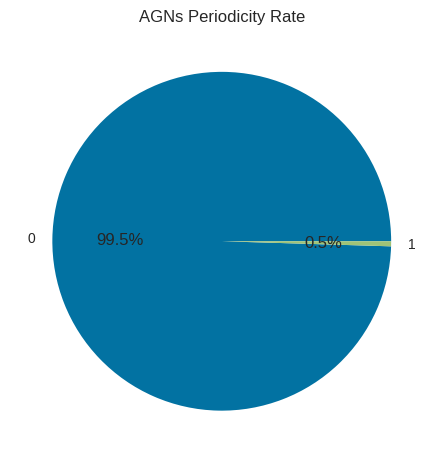

In [96]:
pie_x, pie_y = np.unique(features_df1['Periodicity'], return_counts=True)
plt.pie(pie_y, labels=pie_x, autopct = '%1.1f%%') 
plt.title('AGNs Periodicity Rate')
plt.show()

#### This dataset is very unbalanced.

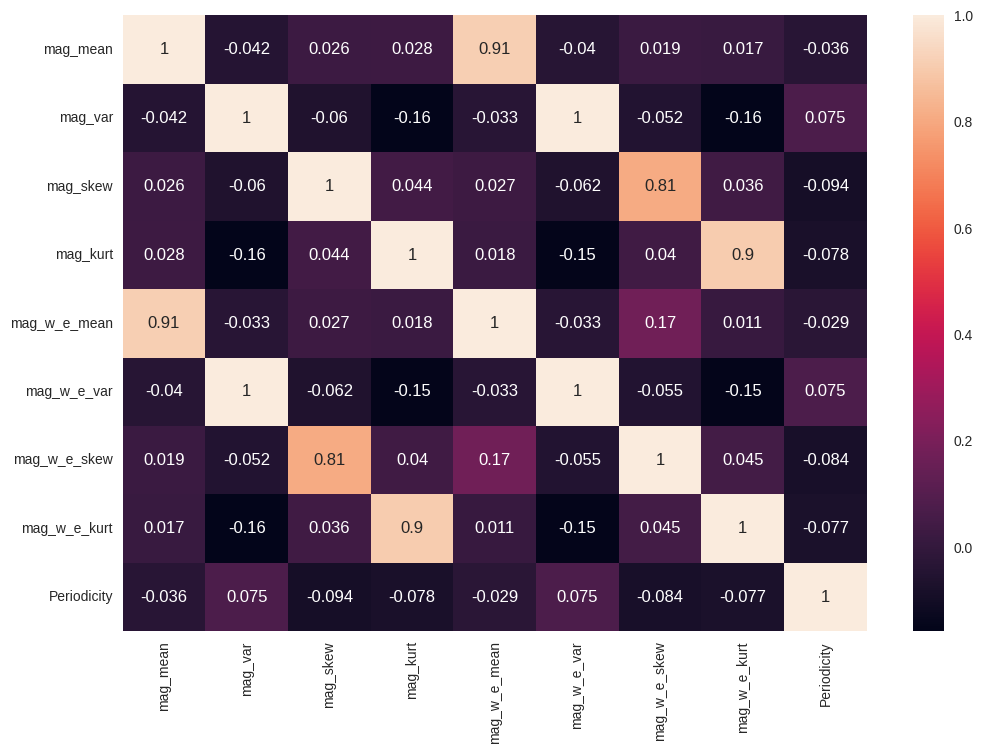

In [97]:
#Perform a correlation matrix to see how the data are related.

plt.figure(figsize=(12,8))
sns.heatmap(features_df1.corr(), annot=True)
plt.show()

In [98]:
features_df1['Periodicity'].value_counts()

Periodicity
0    5200
1      25
Name: count, dtype: int64

In [99]:
df_2 = features_df1[features_df1['Periodicity'] == 0 ].sample(n=100)

In [100]:
df_2

,mag_mean,mag_var,mag_skew,mag_kurt,mag_w_e_mean,mag_w_e_var,mag_w_e_skew,mag_w_e_kurt,Periodicity
678,-0.005600,0.000018,-0.282665,0.606921,0.000625,0.000018,-0.354872,0.674518,0
4025,0.009425,0.000021,-0.281132,-0.452110,0.003225,0.000021,-0.210073,-0.455466,0
4605,0.012775,0.000031,0.158891,-0.666464,0.004775,0.000037,0.007138,-0.481248,0
2649,-0.001150,0.000223,-1.288602,2.273355,-0.022325,0.000258,-1.476928,3.234763,0
498,-0.011250,0.000026,0.434971,-0.049952,-0.003250,0.000026,0.434971,-0.049952,0
...,...,...,...,...,...,...,...,...,...
737,-0.010875,0.000031,0.483277,-0.467998,-0.002875,0.000031,0.483277,-0.467998,0
951,0.014925,0.000024,-0.264590,-0.312571,0.006925,0.000024,-0.264590,-0.312571,0
3289,0.001700,0.000052,-0.191014,-0.568395,-0.010175,0.000050,-0.276275,-0.388844,0
1505,0.010325,0.000148,0.423456,0.028272,-0.005125,0.000142,0.417333,-0.065710,0


In [101]:
df_3 = features_df1[features_df1['Periodicity'] == 1 ].sample(n=25)

In [102]:
df_3

,mag_mean,mag_var,mag_skew,mag_kurt,mag_w_e_mean,mag_w_e_var,mag_w_e_skew,mag_w_e_kurt,Periodicity
1248,-0.006400,0.000968,-0.691676,-0.863887,-0.012400,0.000968,-0.691676,-0.863887,1
1875,-0.005925,0.000934,-0.593488,-0.915212,-0.011925,0.000934,-0.593488,-0.915212,1
203,-0.006975,0.000926,-0.586095,-1.092472,-0.000175,0.000926,-0.578856,-1.138051,1
5010,-0.008400,0.001223,-0.567844,-0.886027,-0.024750,0.001452,-0.538448,-0.874752,1
830,-0.006975,0.000952,-0.602181,-0.987928,-0.000975,0.000952,-0.602181,-0.987928,1
1666,-0.008150,0.000838,-0.465929,-1.004655,0.006575,0.000832,-0.508748,-0.945360,1
412,-0.005750,0.000928,-0.591323,-1.045757,-0.012550,0.000916,-0.619940,-1.030190,1
3338,-0.005625,0.000902,-0.611688,-1.025145,0.002300,0.000911,-0.623331,-0.996666,1
2920,-0.006175,0.001023,-0.698673,-0.839934,0.001825,0.000955,-0.676322,-0.838058,1
5219,-0.005675,0.000906,-0.554417,-0.990547,0.001950,0.000936,-0.523544,-0.960800,1


In [103]:
dfn = pd.concat([df_2, df_3])

In [104]:
dfn.index =  range(dfn.shape[0])

In [105]:
dfn

,mag_mean,mag_var,mag_skew,mag_kurt,mag_w_e_mean,mag_w_e_var,mag_w_e_skew,mag_w_e_kurt,Periodicity
0,-0.005600,0.000018,-0.282665,0.606921,0.000625,0.000018,-0.354872,0.674518,0
1,0.009425,0.000021,-0.281132,-0.452110,0.003225,0.000021,-0.210073,-0.455466,0
2,0.012775,0.000031,0.158891,-0.666464,0.004775,0.000037,0.007138,-0.481248,0
3,-0.001150,0.000223,-1.288602,2.273355,-0.022325,0.000258,-1.476928,3.234763,0
4,-0.011250,0.000026,0.434971,-0.049952,-0.003250,0.000026,0.434971,-0.049952,0
...,...,...,...,...,...,...,...,...,...
120,-0.005225,0.001031,-0.501628,-0.989570,0.006425,0.001050,-0.502706,-0.989255,1
121,-0.007550,0.001131,-0.390459,-1.005621,-0.022950,0.001055,-0.392406,-1.080180,1
122,-0.006475,0.000941,-0.592277,-1.094963,0.000325,0.000913,-0.611679,-1.072850,1
123,-0.006150,0.001005,-0.495720,-1.087437,-0.000100,0.001008,-0.490381,-1.087367,1


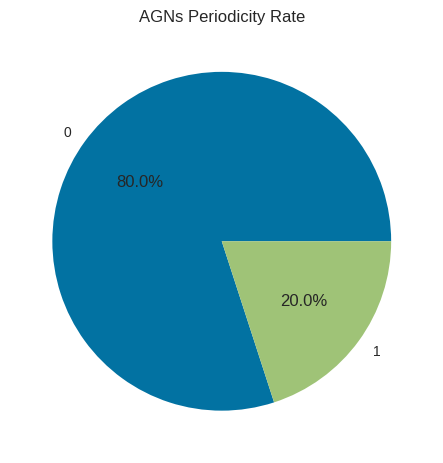

In [106]:
pie_x, pie_y = np.unique(dfn['Periodicity'], return_counts=True)
plt.pie(pie_y, labels=pie_x, autopct = '%1.1f%%') 
plt.title('AGNs Periodicity Rate')
plt.show()

### Machine Learining Models

In [107]:
#Apply a Random Forest classifier with the original dataset.

data2 = features_df1.copy()

# Split the data into features and target
X = data2.drop('Periodicity', axis=1)[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
y = data2['Periodicity']

# Split the dataset into training and testing sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=0.3, random_state=20, stratify = y)

# Initialize the Random Forest Classifier
rf_classifier2 = RandomForestClassifier(max_depth=3)

# Train the model
rf_classifier2.fit(X2_train, y2_train)

# Make predictions on the test set
y2_pred = rf_classifier2.predict(X2_test)

# Evaluate the model
accuracy_score(y2_pred,y2_test)

0.9974489795918368

In [108]:
#Another Machine Learning model, a Random Forest classifier with an undersampling.

# Split the data into features and target
X = dfn.drop('Periodicity', axis=1)[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
y = dfn['Periodicity']

# Split the dataset into training and testing sets
X3_train, X3_test, y3_train, y3_test = train_test_split(X, y, test_size=0.2, random_state=20, stratify = y)

# Initialize the Random Forest Classifier
rf_classifier3 = RandomForestClassifier(max_depth=3)

# Train the model
rf_classifier3.fit(X3_train, y3_train)

# Make predictions on the test set
y3_pred = rf_classifier3.predict(X3_test)

# Evaluate the model
accuracy_score(y3_pred,y3_test)

1.0

In [109]:
#Another Machine Learning model, a Random Forest classifier with an OverSampling.

data = features_df1.copy()

# Split the data into features and target
X = data.drop('Periodicity', axis=1)[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
y = data['Periodicity']

ros = RandomOverSampler(random_state=20, sampling_strategy='minority')

X_res, y_res = ros.fit_resample(X, y)

# Split the dataset into training and testing sets
X4_train, X4_test, y4_train, y4_test = train_test_split(X_res, y_res, test_size=0.3, random_state=20, stratify = y_res)

# Initialize the Random Forest Classifier
rf_classifier4 = RandomForestClassifier(max_depth=3)

# Train the model
rf_classifier4.fit(X4_train, y4_train)

# Make predictions on the test set
y4_pred = rf_classifier4.predict(X4_test)

# Evaluate the model
accuracy_score(y4_pred,y4_test)

1.0

#### We use the metrics to evaluate the model

Metrics for the first model

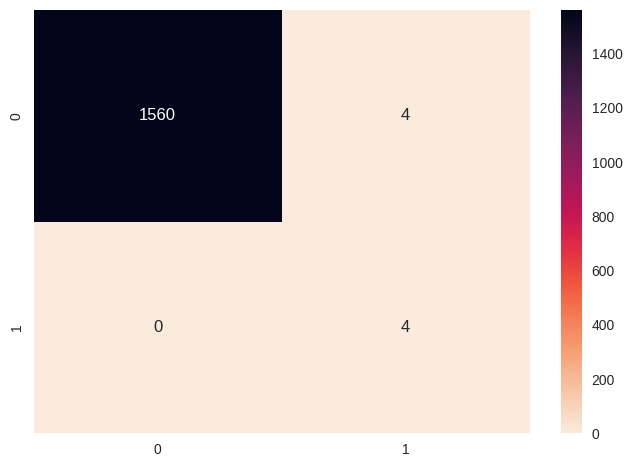

In [110]:
mc=confusion_matrix(y2_pred,y2_test)
mc_norm = mc / np.linalg.norm(mc, axis=1, keepdims=True)
sns.heatmap(pd.DataFrame(mc), cmap=sns.cm.rocket_r, annot=True, fmt='.5g');

In [111]:
cross_val_score(rf_classifier2,X2_train,y2_train,cv=3,scoring='precision').mean()

1.0

In [112]:
cross_val_score(rf_classifier2,X2_train,y2_train,cv=3,scoring='recall').mean()

0.7111111111111111

In [113]:
cross_val_score(rf_classifier2,X2_train,y2_train,cv=3,scoring='f1').mean()

0.865993265993266

Metrics of second Random Forest Model

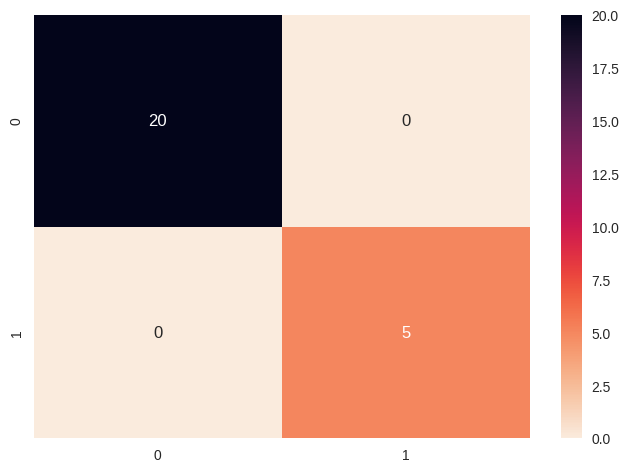

In [114]:
mc=confusion_matrix(y3_pred,y3_test)
mc_norm = mc / np.linalg.norm(mc, axis=1, keepdims=True)
sns.heatmap(pd.DataFrame(mc), cmap=sns.cm.rocket_r, annot=True, fmt='.5g');

In [115]:
cross_val_score(rf_classifier3,X3_train,y3_train,cv=3,scoring='precision').mean()

0.9583333333333334

In [116]:
cross_val_score(rf_classifier3,X3_train,y3_train,cv=3,scoring='recall').mean()

1.0

In [117]:
cross_val_score(rf_classifier3,X3_train,y3_train,cv=3,scoring='f1').mean()

0.9777777777777779

Metrics of the last Model

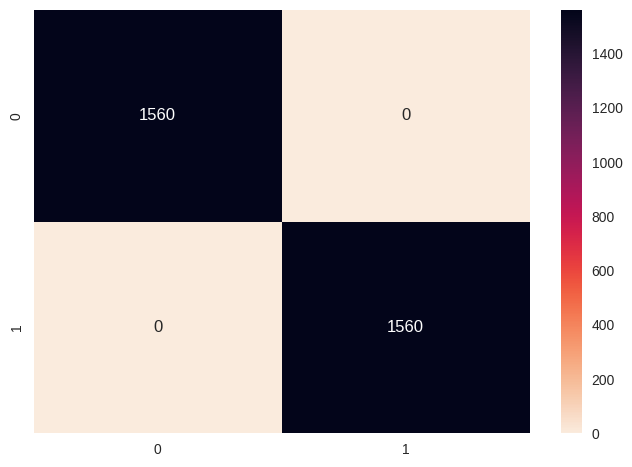

In [118]:
mc=confusion_matrix(y4_pred,y4_test)
mc_norm = mc / np.linalg.norm(mc, axis=1, keepdims=True)
sns.heatmap(pd.DataFrame(mc), cmap=sns.cm.rocket_r, annot=True, fmt='.5g');

In [119]:
cross_val_score(rf_classifier4,X4_train,y4_train,cv=3,scoring='precision').mean()

0.9989023803228453

In [120]:
cross_val_score(rf_classifier4,X4_train,y4_train,cv=3,scoring='recall').mean()

1.0

In [121]:
cross_val_score(rf_classifier4,X4_train,y4_train,cv=3,scoring='f1').mean()

0.9994508511340939

#### We'll try with one more model, whit an OverSampling in the undersampled dataset

In [122]:
#Another Machine Learning model, a Random Forest classifier with an undersampling.

# Split the data into features and target
X = dfn.drop('Periodicity', axis=1)[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
y = dfn['Periodicity']

ros = RandomOverSampler(random_state=20, sampling_strategy='minority')

X_res, y_res = ros.fit_resample(X, y)

# Split the dataset into training and testing sets
X5_train, X5_test, y5_train, y5_test = train_test_split(X_res, y_res, test_size=0.2, random_state=20, stratify = y_res)

# Initialize the Random Forest Classifier
rf_classifier5 = RandomForestClassifier(max_depth=10)

# Train the model
rf_classifier5.fit(X5_train, y5_train)

# Make predictions on the test set
y5_pred = rf_classifier5.predict(X5_test)

# Evaluate the model
accuracy_score(y5_pred,y5_test)

1.0

Calculate the metrics

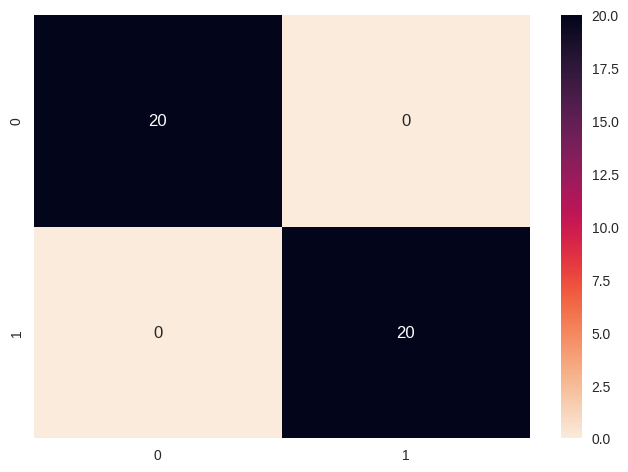

In [123]:
mc=confusion_matrix(y5_pred,y5_test)
mc_norm = mc / np.linalg.norm(mc, axis=1, keepdims=True)
sns.heatmap(pd.DataFrame(mc), cmap=sns.cm.rocket_r, annot=True, fmt='.5g');

In [124]:
cross_val_score(rf_classifier5,X5_train,y5_train,cv=3,scoring='precision').mean()

0.9655172413793104

In [125]:
cross_val_score(rf_classifier5,X5_train,y5_train,cv=3,scoring='recall').mean()

1.0

In [126]:
cross_val_score(rf_classifier5,X5_train,y5_train,cv=3,scoring='f1').mean()

0.9818181818181818

#### Let's try with one last model, using only the variable AGNs for the training set.

In [130]:
#we go through all the subdirectories corresponding to each AGN and in each one all the files with different sintetics curvs 

path = '/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/' #path to main directory
filelist = os.listdir(path)

#Make empty list to store all paths to subdirectories in.
path2 = []
data_features = []
data_features2 = []
Periodicity = []

for x in filelist:
    if x.startswith('orig'):
        path2.append(path + x+ '/')
    
    for i in path2:
        filelist2 = os.listdir(i)
        
        for j in filelist2:
            if j.endswith('.dat'):
                dt = np.loadtxt(i+j)
                 
                star = agns(dt)[2]
                err_star = agns(dt)[3]
                data_features1 = dataframe1(dt, 9, 1, star, err_star, 4, 5, 3)

                # Convert lists to a DataFrame
                features_df2 = pd.DataFrame(data_features)
                features_df2 = pd.DataFrame(data_features1)
                features_df2['Periodicity'] = Periodicity       
    path2 = []

In [131]:
features_df2

,mag_mean,mag_var,mag_skew,mag_kurt,mag_w_e_mean,mag_w_e_var,mag_w_e_skew,mag_w_e_kurt,Periodicity
0,-0.012175,0.003481,0.009732,-1.166892,-0.018975,0.003385,0.000260,-1.152263,0
1,-0.012625,0.003308,-0.004153,-1.203946,-0.005925,0.003228,0.002411,-1.191345,0
2,-0.008000,0.002163,-0.930161,-0.498298,-0.015050,0.002118,-0.924007,-0.501353,0
3,-0.006975,0.000926,-0.586095,-1.092472,-0.013775,0.000929,-0.591546,-1.042295,1
4,-0.007925,0.005771,-0.039005,-0.418268,-0.000125,0.005815,-0.039427,-0.422284,0
...,...,...,...,...,...,...,...,...,...
220,0.014050,0.012010,0.297835,-1.603264,0.023050,0.011964,0.295835,-1.594466,0
221,0.007875,0.003598,-0.212056,-1.291822,0.016800,0.003560,-0.201859,-1.280869,0
222,0.000025,0.001727,0.374140,-0.896395,0.008950,0.001736,0.381997,-0.906512,0
223,-0.011825,0.001101,-0.246812,-1.147553,-0.020750,0.001114,-0.230340,-1.191427,0


In [132]:
features_df2['Periodicity'].value_counts()

Periodicity
0    200
1     25
Name: count, dtype: int64

In [133]:
#Another Machine Learning model, a Random Forest classifier with an OverSampling.

data = features_df2.copy()

# Split the data into features and target
X = data.drop('Periodicity', axis=1)[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
y = data['Periodicity']

ros = RandomOverSampler(random_state=20, sampling_strategy='minority')

X_res, y_res = ros.fit_resample(X, y)

# Split the dataset into training and testing sets
X6_train, X6_test, y6_train, y6_test = train_test_split(X, y, test_size=0.2, random_state=20, stratify = y)

# Initialize the Random Forest Classifier
rf_classifier6 = RandomForestClassifier(max_depth=3)

# Train the model
rf_classifier6.fit(X6_train, y6_train)

# Make predictions on the test set
y6_pred = rf_classifier6.predict(X6_test)

# Evaluate the model
accuracy_score(y6_pred,y6_test)

1.0

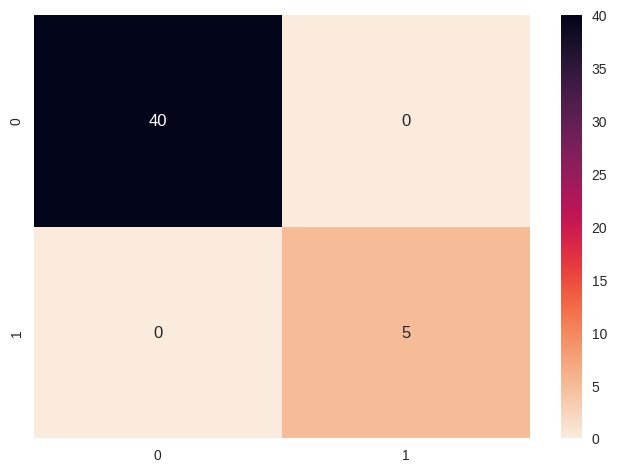

In [134]:
mc=confusion_matrix(y6_pred,y6_test)
mc_norm = mc / np.linalg.norm(mc, axis=1, keepdims=True)
sns.heatmap(pd.DataFrame(mc), cmap=sns.cm.rocket_r, annot=True, fmt='.5g');

In [135]:
cross_val_score(rf_classifier6,X6_train,y6_train,cv=3,scoring='precision').mean()

1.0

In [136]:
cross_val_score(rf_classifier6,X6_train,y6_train,cv=3,scoring='recall').mean()

0.8492063492063492

In [137]:
cross_val_score(rf_classifier6,X6_train,y6_train,cv=3,scoring='f1').mean()

0.9440559440559441

In [138]:
#Precision score
precision_score(y6_pred, y6_test)

1.0

In [139]:
#ROC AUC score
roc_auc_score(y6_pred,y6_test)

1.0

In [140]:
#Recall score
recall_score(y6_test, y6_pred) 

1.0

In [141]:
#F1 score
f1_score(y6_test, y6_pred) 

1.0

In [142]:
print(classification_report(y6_test,y6_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00         5

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



#### Let's try an other classifier model, an XGBoost.

In [143]:
# Scaling the data

data = features_df2.copy()

# Split the data into features and target
X = data.drop('Periodicity', axis=1)[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
y = data['Periodicity']

ros = RandomOverSampler(random_state=20, sampling_strategy='minority')

X_res, y_res = ros.fit_resample(X, y)

# Split the dataset into training and testing sets
Xg_train, Xg_test, yg_train, yg_test = train_test_split(X_res, y_res, test_size=0.2, random_state=20, stratify = y_res)

X_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()

# Fitting the scalers and transforming the training sets
Xg_train = X_scaler.fit_transform(Xg_train)
yg_train = y_scaler.fit_transform((yg_train).to_numpy().reshape(-1,1))

# Transforming the test set
Xg_test = X_scaler.transform(Xg_test)
#yg_test = y_scaler.transform((yg_test).to_numpy().reshape(-1,1))

In [144]:
#XGBoost

xgbr = xgb.XGBClassifier(n_estimators=500)

# Fitting XGBoost
xgbr.fit(Xg_train, yg_train)

# Predicting for the test set
yg_pred = xgbr.predict(Xg_test)
yg_pred = y_scaler.inverse_transform(yg_pred.reshape(-1,1))

In [145]:
# Metrics of the XGBoost prediction

#from sklearn.metrics import mean_squared_error, r2_score
score_xgb = r2_score(yg_test, yg_pred)
std_xgb = np.sqrt(mean_squared_error(yg_test, yg_pred))
print("The R2 was:", score_xgb)
print("The RMSE was:", std_xgb)

The R2 was: 0.95
The RMSE was: 0.11180339887498948


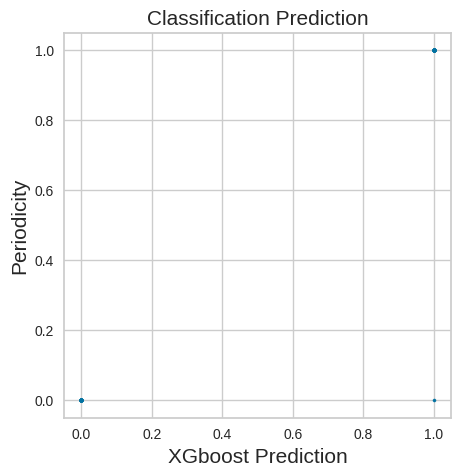

In [146]:
# Plotting the predict
plt.figure(figsize=(5,5))
plt.scatter(yg_pred, yg_test, s=5)
plt.title("Classification Prediction", fontsize=15)
plt.xlabel("XGboost Prediction", fontsize=15)
plt.ylabel("Periodicity", fontsize=15)
plt.show()

## PyCaret AutoML

In [151]:
features_df1['Periodicity'].value_counts()

Periodicity
0    5200
1      25
Name: count, dtype: int64

In [152]:
features_df1.columns

Index(['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt', 'mag_w_e_mean',
       'mag_w_e_var', 'mag_w_e_skew', 'mag_w_e_kurt', 'Periodicity'],
      dtype='object')

In [158]:
# Setup the classification model
clf1 = setup(data=features_df1[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt','Periodicity']], target='Periodicity',fix_imbalance=True)

,Description,Value
0,Session id,5226
1,Target,Periodicity
2,Target type,Binary
3,Original data shape,"(5225, 5)"
4,Transformed data shape,"(8848, 5)"
5,Transformed train set shape,"(7280, 5)"
6,Transformed test set shape,"(1568, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


In [162]:
# Compare the performance of different classification models
best_model = compare_models(include = ['lr', 'knn', 'dt', 'rf', 'xgboost'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9992,0.9997,0.9000,0.9667,0.9133,0.9130,0.9228,0.2250
dt,Decision Tree Classifier,0.9989,0.9497,0.9000,0.9167,0.8967,0.8961,0.9019,0.0240
xgboost,Extreme Gradient Boosting,0.9989,0.9996,0.9000,0.9500,0.9000,0.8995,0.9117,0.0450
knn,K Neighbors Classifier,0.9984,0.9743,0.9500,0.8667,0.8800,0.8793,0.8932,0.0460
lr,Logistic Regression,0.9839,0.9986,1.0000,0.2625,0.4042,0.3997,0.4975,0.0280


In [163]:
best_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=5226, verbose=0,
                       warm_start=False)

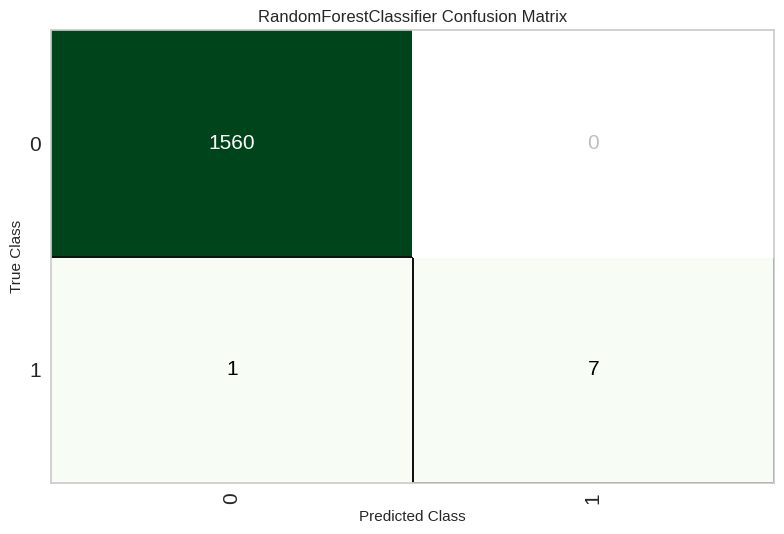

In [164]:
# plot confusion matrix
plot_model(best_model, plot = 'confusion_matrix')

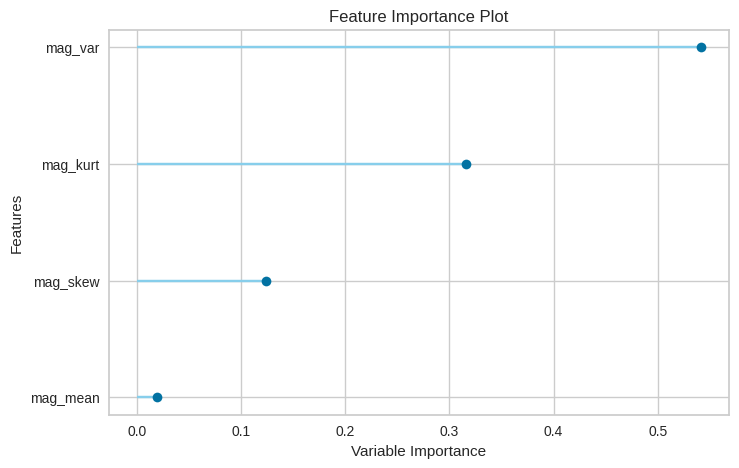

In [165]:
# plot feature importance
plot_model(best_model, plot = 'feature')

In [166]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [168]:
tuned_model = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,0.9973,0.9986,0.5000,1.0000,0.6667,0.6654,0.7061
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.9973,0.9945,0.5000,1.0000,0.6667,0.6654,0.7061
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,0.9945,1.0000,1.0000,0.5000,0.6667,0.6642,0.7052
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [169]:
tuned_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=5226, verbose=0,
                       warm_start=False)

In [170]:
# predict on test set
holdout_pred = predict_model(tuned_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9994,1.0000,0.8750,1.0000,0.9333,0.9330,0.9351


In [171]:
# save the model in a variable to use for prediction
final_best_model1 = finalize_model(tuned_model)

In [172]:
# show predictions df
holdout_pred.head()

,mag_mean,mag_var,mag_skew,mag_kurt,Periodicity,prediction_label,prediction_score
4164,0.104625,0.000056,-0.577994,-0.233964,0,0,1.0
5144,-0.011200,0.000095,0.287901,1.098232,0,0,1.0
3781,-0.013975,0.000067,0.182321,0.187701,0,0,1.0
3835,-0.012725,0.000118,-0.229370,-0.331235,0,0,1.0
499,-0.007125,0.000034,-0.100702,-0.322511,0,0,1.0


In [175]:
#we go through all the subdirectories corresponding to each AGN and in each one all the files with different observations and we make a classification for each observation.

path = '/home/anakin/Documents/Tesis/Codigo/AGNs/' #path to main directory
filelist = os.listdir(path)
df_obs_p = []
names1 = []
k=0
#Make empty list to store all paths to subdirectories in.
path2 = []
for x in filelist:
    if x.startswith('agn'):
        path2.append(path + x+ '/')

for i in path2:
    filelist2 = os.listdir(i)
    c=0
    p=0
    for j in filelist2:
        if j.endswith('.csv'):
            file = pd.read_csv(i+j, dtype=np.float64, na_values='INDEF')
            long= len(file['D1'])

            data_features_obs = []

            features_obs = dataframe_obs(file)[0]

            # Store the features 
            data_features_obs.append(features_obs) 
                
            # Convert lists to a DataFrame
            features_df_per = pd.DataFrame(data_features_obs)

            # Predict with the model
            predicted_per = final_best_model1.predict(features_df_per)
    
            print(j, ':Classified', predicted_per, 'with', long, 'observations')

            c+=1
            if predicted_per == 1:
                
                df_obs_p.append(features_obs)
                names1.append(j)

                p+=1
                
    prob = p/c*100

    print('-------------------------------------------------',names_agns[k], 'is Periodic whit a probability of:', prob, '%')
    k+=1

# Convert lists to a DataFrame
df_obs_p = pd.DataFrame(df_obs_p)
df_obs_p['AGN_n_obs'] = names1

 # Save the DataFrame to a CSV file
df_obs_p.to_csv('observations_AGNs.csv', index=False)

1424R-140415.csv :Classified [0] with 9 observations
1424V-140415.csv :Classified [0] with 9 observations
------------------------------------------------- agn_1424 is Periodic whit a probability of: 0.0 %
0521V-111215.csv :Classified [0] with 21 observations
0521R-111215.csv :Classified [0] with 20 observations
------------------------------------------------- agn_0521 is Periodic whit a probability of: 0.0 %
1116R-130415.csv :Classified [0] with 15 observations
1116R-140415.csv :Classified [0] with 12 observations
1116V-130415.csv :Classified [0] with 15 observations
1116V-140415.csv :Classified [0] with 12 observations
------------------------------------------------- agn_1116 is Periodic whit a probability of: 0.0 %
1229V-120415.csv :Classified [0] with 13 observations
1229R-120415.csv :Classified [0] with 13 observations
------------------------------------------------- agn_1229 is Periodic whit a probability of: 0.0 %
1958V-230414.csv :Classified [0] with 11 observations
1958R-24

In [176]:
df_obs_p

,AGN_n_obs


#### One more time, we'll predcit using the magnitudes with erros variables. We do this to verify if the observationals errors are sufficiently significant to change our predictions.

In [177]:
#we go through all the subdirectories corresponding to each AGN and in each one all the files with different observations and we make a classification for each observation.

path = '/home/anakin/Documents/Tesis/Codigo/AGNs/' #path to main directory
filelist = os.listdir(path)
df_obs_p_err = []
names1 = []
k=0
#Make empty list to store all paths to subdirectories in.
path2 = []
for x in filelist:
    if x.startswith('agn'):
        path2.append(path + x+ '/')

for i in path2:
    filelist2 = os.listdir(i)
    c=0
    p=0
    for j in filelist2:
        if j.endswith('.csv'):
            file = pd.read_csv(i+j, dtype=np.float64, na_values='INDEF')
            long= len(file['D1'])

            data_features_obs = []

            features_obs = dataframe_obs(file)[1]

            # Store the features 
            data_features_obs.append(features_obs) 
                
            # Convert lists to a DataFrame
            features_df_per = pd.DataFrame(data_features_obs)

            # Predict with the model
            predicted_per = final_best_model1.predict(features_df_per)
    
            print(j, ':Classified', predicted_per, 'with', long, 'observations')

            c+=1
            if predicted_per == 1:
                
                df_obs_p_err.append(features_obs)
                names1.append(j)

                p+=1
                
    prob = p/c*100

    print('-------------------------------------------------',names_agns[k], 'is Periodic whit a probability of:', prob, '%')
    k+=1

# Convert lists to a DataFrame
df_obs_p_err = pd.DataFrame(df_obs_p_err)
df_obs_p_err['AGN_n_obs'] = names1

 # Save the DataFrame to a CSV file
df_obs_p_err.to_csv('observations_AGNs.csv', index=False)

1424R-140415.csv :Classified [0] with 9 observations
1424V-140415.csv :Classified [0] with 9 observations
------------------------------------------------- agn_1424 is Periodic whit a probability of: 0.0 %
0521V-111215.csv :Classified [0] with 21 observations
0521R-111215.csv :Classified [0] with 20 observations
------------------------------------------------- agn_0521 is Periodic whit a probability of: 0.0 %
1116R-130415.csv :Classified [0] with 15 observations
1116R-140415.csv :Classified [0] with 12 observations
1116V-130415.csv :Classified [0] with 15 observations
1116V-140415.csv :Classified [0] with 12 observations
------------------------------------------------- agn_1116 is Periodic whit a probability of: 0.0 %
1229V-120415.csv :Classified [0] with 13 observations
1229R-120415.csv :Classified [0] with 13 observations
------------------------------------------------- agn_1229 is Periodic whit a probability of: 0.0 %
1958V-230414.csv :Classified [0] with 11 observations
1958R-24

In [178]:
df_obs_p

,AGN_n_obs


In [179]:
df_obs_p_err

,AGN_n_obs


## Errors and test de ML model

#### In this last section we will estimate a threshold for the number of observations for the use of the model. 
#### On the other hand, we'll compare and test de ML model whit a Fisher test, what is the most used in the literature.

In [180]:
def dataframe_th(df, N, p, star, err_star, c, x, i): # p is the value of the target variable. 1 for variable AGNs and 0 for non-viarable AGNs
                                               # df and star must have the same subindex


    agn_a = agns(df)[c]
    agn = agn_a[i]

    err_a = agns(df)[x]
    err_agn = err_a[i]

    #Calculates the calibrated magnitude of the AGN
    mag = calibration(agn, star, err_agn, err_star)[0]

    return mag

In [181]:
#Here we will calculate the threshold of the observations. This function iteratively deletes the last point of the observations 
#until the model prediction changes, and the number of points left in this last iteration is the threshold.

def threshold(df, model):

    star = agns(df)[2]
    err_star = agns(df)[3]

    for j in range(9):
    
        mag = dataframe_th(df, 9, 1, star, err_star, 4, 5, j)

        #Calculate de initial prediction to compare
        features_in = extract_features_obs(mag, 0, 0)[0]
        features_in = pd.DataFrame(features_in, index=[0])
        features_in
    
        prediction_in = model.predict(features_in)
        
        for i in range(len(mag)): 
    
            #Delete de last item of the observations
            mag = np.delete(mag, -1)
            
            # Extract features from the time series data
            features = extract_features_obs(mag, 0, 0)[0]
            features = pd.DataFrame(features, index=[0])
        
            prediction = model.predict(features)

            if len(mag) == 2:
    
                print('limit')
                break
                
            elif prediction != prediction_in:
    
                print('Threshold =', len(mag))
                break            

In [184]:
#we go through all the subdirectories corresponding to each AGN and in each one all the files with different sintetics curvs 

path = '/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/' #path to main directory
filelist = os.listdir(path)

#Make empty list to store all paths to subdirectories in.
path2 = []

for x in filelist:
    if x.startswith('orig'):
        path2.append(path + x+ '/')
    
    for i in path2:
        filelist2 = os.listdir(i)
        
        for j in filelist2:
            if j.endswith('.dat'):
                dt = np.loadtxt(i+j)
                
                #Calculate de threshold for variability classifier

            print('df:', i, '-----------------------------')
            threshold(dt,final_best_model)
                      
    path2 = []

df: /home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig20/ -----------------------------
Threshold = 14
Threshold = 18
Threshold = 16
Threshold = 14
limit
limit
limit
limit
Threshold = 6
df: /home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig19/ -----------------------------
Threshold = 15
Threshold = 17
Threshold = 15
Threshold = 14
limit
limit
limit
Threshold = 4
Threshold = 39
df: /home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig08/ -----------------------------
Threshold = 14
Threshold = 17
Threshold = 15
Threshold = 14
limit
limit
Threshold = 3
Threshold = 8
Threshold = 12
df: /home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig01/ -----------------------------
Threshold = 15
Threshold = 16
Threshold = 16
Threshold = 14
limit
limit
limit
Threshold = 28
Threshold = 37
df: /home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig02/ -----------------------------
Threshold = 14
Threshold = 17
Threshold = 16
Threshold = 14
limit
limit
limit
limit
Threshold = 2

In [185]:
#Now we will compute a Fisher test

#we go through all the subdirectories corresponding to each AGN and in each one all the files with different observations and we make a classification for each observation.

path = '/home/anakin/Documents/Tesis/Codigo/AGNs/' #path to main directory
filelist = os.listdir(path)
k=0

#Make empty list to store all paths to subdirectories in.
path2 = []
for x in filelist:
    if x.startswith('agn'):
        path2.append(path + x+ '/')

for i in path2:
    filelist2 = os.listdir(i)
    print(names_agns[k])
    for j in filelist2:
        if j.endswith('.csv'):
            file = pd.read_csv(i+j, dtype=np.float64, na_values='INDEF')
            
            D1 = file['D1']#Diference between AGN and calibration star magnitudes
            D2 = file['D2']#Diference between calibratoin and control star magnitudes
             
            # Calculate the sample variances
            var1 = np.var(D1, ddof=1)
            var2 = np.var(D2, ddof=1)
             
            # Calculate the F-statistic
            f_value = var1 / var2
             
            # Calculate the degrees of freedom
            df1 = len(D1) - 1
            df2 = len(D2) - 1
             
            # Calculate the p-value
            p_value = stats.f.cdf(f_value, df1, df2)
             
            # Print the results
            print("p-value:", p_value)

    k+=1

agn_1424
p-value: 0.8544797034099689
p-value: 0.9914420581971368
agn_0521
p-value: 0.9999963029581306
p-value: 0.999849394848954
agn_1116
p-value: 0.9297694829409705
p-value: 0.9995483600034191
p-value: 0.9999952891647831
p-value: 0.9999579999131025
agn_1229
p-value: 0.011110477400956994
p-value: 0.2827159613269124
agn_1958
p-value: 0.9852193989452965
p-value: 0.5242552024449725
p-value: 0.20314007216140378
p-value: 0.19951104708674253
agn_1510
p-value: 0.34883262612755433
p-value: 0.8938319019376578
p-value: 0.8851116458924585
p-value: 0.5988911488924056
p-value: 0.9991436126142565
p-value: 0.999989142482597
p-value: 0.8731367891144431
p-value: 0.3418400377635348
p-value: 0.9988388939496877
p-value: 0.9590388727856686
p-value: 0.9999982817322463
p-value: 0.5834743710690735
p-value: 0.9999991615069811
p-value: 0.18106264379952094
p-value: 0.9979171028655993
p-value: 0.4983771808583888
p-value: 0.9909736907448662
p-value: 0.9998443475766128
p-value: 0.9982903512266169
p-value: 0.9948153

In [186]:
df_obs

,mag_mean,mag_var,mag_skew,mag_kurt,AGN_n_obs,Observations
0,0.040444,0.000665,0.501270,-0.884148,1424V-140415.csv,9
1,0.112933,0.000857,0.050781,-1.129494,1116V-130415.csv,15
2,0.227833,0.001494,0.611344,-1.191094,1116V-140415.csv,12
3,0.482750,0.003018,1.471751,1.302412,1510V-040419.csv,8
4,0.855000,0.001063,0.065795,-1.326321,0208R-130815.csv,9
5,1.327667,0.002670,0.494768,-1.370405,0208V-150915.csv,6
6,0.685889,0.000977,-0.312898,-1.128564,0208V-130815.csv,9
7,0.687000,0.001165,0.488886,-1.020814,2149V-120815.csv,4
8,0.678071,0.000681,0.542535,-0.866700,2155V-150915.csv,14


In [187]:
path = '/home/anakin/Documents/Tesis/Codigo/AGNs/' #path to main directory
filelist = os.listdir(path)
df_obs_err = []
names1 = []
observations = []
k=0
#Make empty list to store all paths to subdirectories in.
path2 = []
for x in filelist:
    if x.startswith('agn'):
        path2.append(path + x+ '/')

for i in path2:
    filelist2 = os.listdir(i)
    c=0
    p=0
    for j in filelist2:
        if j.endswith('.csv'):
            file = pd.read_csv(i+j, dtype=np.float64, na_values='INDEF')
            long= len(file['D1'])

            err_features_obs = []

            features_obs = dataframe_obs(file)[1]
            
            # Store the features 
            err_features_obs.append(features_obs)    
                
            # Convert lists to a DataFrame
            features_df_var = pd.DataFrame(err_features_obs)

            # Predict with the model
            predicted = final_best_model.predict(features_df_var)

            D1 = file['D1']#Diference between AGN and calibration star magnitudes
            D2 = file['D2']#Diference between calibratoin and control star magnitudes
             
            # Calculate the sample variances
            var1 = np.var(D1, ddof=1)
            var2 = np.var(D2, ddof=1)
             
            # Calculate the F-statistic
            f_value = var1 / var2
             
            # Calculate the degrees of freedom
            df1 = len(D1) - 1
            df2 = len(D2) - 1
             
            # Calculate the p-value
            p_value = stats.f.cdf(f_value, df1, df2)
    
            print(j, ':Classified', predicted, 'with', long, 'observations','|' 'p_value', p_value)

            c+=1
            if predicted == 1:
                
                df_obs_err.append(features_obs)
                names1.append(j)
                observations.append(long)

                p+=1
                
    prob = p/c*100

    print('-------------------------------------------------',names_agns[k], 'is variable whit a probability of:', prob, '%')
    k+=1

# Convert lists to a DataFrame
df_obs_err = pd.DataFrame(df_obs_err)
df_obs_err['AGN_n_obs'] = names1
df_obs_err['Observations'] = observations

1424R-140415.csv :Classified [0] with 9 observations |p_value 0.8544797034099689
1424V-140415.csv :Classified [1] with 9 observations |p_value 0.9914420581971368
------------------------------------------------- agn_1424 is variable whit a probability of: 50.0 %
0521V-111215.csv :Classified [0] with 21 observations |p_value 0.9999963029581306
0521R-111215.csv :Classified [0] with 20 observations |p_value 0.999849394848954
------------------------------------------------- agn_0521 is variable whit a probability of: 0.0 %
1116R-130415.csv :Classified [0] with 15 observations |p_value 0.9297694829409705
1116R-140415.csv :Classified [0] with 12 observations |p_value 0.9995483600034191
1116V-130415.csv :Classified [1] with 15 observations |p_value 0.9999952891647831
1116V-140415.csv :Classified [1] with 12 observations |p_value 0.9999579999131025
------------------------------------------------- agn_1116 is variable whit a probability of: 50.0 %
1229V-120415.csv :Classified [0] with 13 obse